# Facebook Post Recommender

In [ ]:
import pickle
import shutil
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
import random

import torch
from torchvision import models
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
!pip install img2vec_pytorch

In [ ]:
from img2vec_pytorch import Img2Vec

## Download Images

In [ ]:
!pip install img2dataset

     |████████████████████████████████| 133 kB 16.0 MB/s 
     |████████████████████████████████| 87 kB 8.7 MB/s 
     |████████████████████████████████| 1.7 MB 45.7 MB/s 
     |████████████████████████████████| 47 kB 819 kB/s 
     |████████████████████████████████| 60.5 MB 1.5 MB/s 
     |████████████████████████████████| 102 kB 49.9 MB/s 
     |████████████████████████████████| 47.8 MB 63 kB/s 
     |████████████████████████████████| 144 kB 76.1 MB/s 
     |████████████████████████████████| 181 kB 67.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=fcd5cdb7471aa0f5bb858d1b72b3ae41c5f949c25a9869d4e60ece7cb68255c3
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5f9ae1280fa17399f40824c904f4c6bc5b96d07dc938c6a3ed534000806097ab
  Stored in di

In [ ]:
!img2dataset --url_list=/content/ad_photo_recommendation/img_list.txt --output_folder=output_folder --thread_count=64 --image_size=256

Starting the downloading of this file
Sharding file number 1 of 1 called /content/ad_photo_recommendation/img_list.txt
0it [00:00, ?it/s]File sharded in 1 shards
1it [00:10, 10.29s/it]
worker  - success: 0.179 - failed to download: 0.821 - failed to resize: 0.000 - images per sec: 40 - count: 168
total   - success: 0.179 - failed to download: 0.821 - failed to resize: 0.000 - images per sec: 40 - count: 168


In [ ]:
# Save folder as a zip file
shutil.make_archive('output_folder', 'zip', 'output_folder') # Save folder as a zip file

'/content/output_folder.zip'

In [ ]:
%ls

ad_photo_recommendation/  output_folder/  output_folder.zip  sample_data/


In [ ]:
# Get all image names in the folder
image_names = []
for filename in os.listdir('output_folder/00000'):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        print(filename)
        image_names.append(filename)

# Get the URL of each image
urls = []
for imagename in image_names:
  url = pd.read_json("output_folder/00000/"+imagename.replace("jpg", "json"), typ='series')[0]
  urls.append(url)

000000159.jpg
000000138.jpg
000000151.jpg
000000156.jpg
000000150.jpg
000000144.jpg
000000147.jpg
000000157.jpg
000000141.jpg
000000146.jpg
000000140.jpg
000000166.jpg
000000162.jpg
000000145.jpg
000000139.jpg
000000142.jpg
000000158.jpg
000000164.jpg
000000143.jpg
000000163.jpg
000000154.jpg
000000153.jpg
000000167.jpg
000000148.jpg
000000155.jpg
000000160.jpg
000000149.jpg
000000161.jpg
000000165.jpg
000000152.jpg


In [ ]:
pd.set_option('display.max_colwidth', None)
fb_images = pd.DataFrame({"Image_Name": image_names, "URL":urls})
fb_images.head(2)

,Image_Name,URL
0,000000159.jpg,https://scontent-atl3-2.xx.fbcdn.net/v/t1.6435-9/166512863_4136679206356556_5180987667655029225_n.jpg?_nc_cat=107&ccb=1-5&_nc_sid=9267fe&_nc_ohc=E_2BFlcD8WoAX-wc8mN&_nc_ht=scontent-atl3-2.xx&oh=00_AT_OLKLqR-1RTL4Gce3jONHRRt91ag5wt0t-QufgdjUt4g&oe=626CBAC4
1,000000138.jpg,https://scontent-atl3-2.xx.fbcdn.net/v/t1.6435-9/177517130_4218718744819268_4973356281864646664_n.jpg?_nc_cat=106&ccb=1-5&_nc_sid=9267fe&_nc_ohc=0vLOQKW0B3oAX9aiTHr&_nc_ht=scontent-atl3-2.xx&oh=00_AT-_VGAwxM7c4w6b-w_Sl_UvC4cof68JY6fwzF22ZyYfhw&oe=626BC548


In [ ]:
#fb_images.to_csv("fb_images.csv")

## Embeddings

In [ ]:
# Copy the image folder to clean it by removing json files and keep only jpg's
%cp -av output_folder/00000 images_only

'output_folder/00000' -> 'images_only'
'output_folder/00000/000000159.jpg' -> 'images_only/000000159.jpg'
'output_folder/00000/000000159.json' -> 'images_only/000000159.json'
'output_folder/00000/000000157.jpg' -> 'images_only/000000157.jpg'
'output_folder/00000/000000157.json' -> 'images_only/000000157.json'
'output_folder/00000/000000144.jpg' -> 'images_only/000000144.jpg'
'output_folder/00000/000000144.json' -> 'images_only/000000144.json'
'output_folder/00000/000000147.jpg' -> 'images_only/000000147.jpg'
'output_folder/00000/000000147.json' -> 'images_only/000000147.json'
'output_folder/00000/000000143.jpg' -> 'images_only/000000143.jpg'
'output_folder/00000/000000143.json' -> 'images_only/000000143.json'
'output_folder/00000/000000141.jpg' -> 'images_only/000000141.jpg'
'output_folder/00000/000000141.json' -> 'images_only/000000141.json'
'output_folder/00000/000000153.jpg' -> 'images_only/000000153.jpg'
'output_folder/00000/000000153.json' -> 'images_only/000000153.json'
'output_f

In [ ]:
# Remove json files
dir_name = "images_only"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".json"):
        os.remove(os.path.join(dir_name, item))

In [ ]:
inputDim = (224,224)
inputDir = "images_only"
inputDirCNN = "inputImagesCNN"

os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])


for imageName in os.listdir(inputDir):
  try:
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)

    newI.save(os.path.join(inputDirCNN, imageName))
    
    newI.close()
    I.close()
  except Exception as e:
    pass
    print(e)
    logging.error(traceback.format_exc())


In [ ]:
# Generate Embeddings

#img2vec = Img2Vec(cuda=True, model='vgg')
#img2vec = Img2Vec(cuda=True, model='densenet')
img2vec = Img2Vec(cuda=True, model='efficientnet_b0')

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("inputImagesCNN")):
  try:
    I = Image.open(os.path.join("inputImagesCNN", image))
    vec = img2vec.get_vec(I)
    allVectors[image] = vec
    I.close() 
  except:
    pass

Converting images to feature vectors:


100%|██████████| 30/30 [00:00<00:00, 99.66it/s]


In [ ]:
# Save embedding vectors
with open('PyschobunnyAllVectors.pkl', 'wb') as handle:
    pickle.dump(allVectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('PyschobunnyAllVectors.pkl', 'rb') as handle:
    allVectors = pickle.load(handle)

# close file
#f.close()

## Recommendation System

In [ ]:
def getSimilarityMatrix(vectors):
    """
    Function to calculate the cosine similarity between vectors.
    
    Parameters
    ----------
    vectors : matrix
        Matrix with all of the embeddings.

    matrix : dataframe
        Dataframe with the cosine similarity between all vectors.
    """
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [ ]:
# Top 10 Images
k = 10 

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

# Save the model    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 30/30 [00:00<00:00, 1722.20it/s]


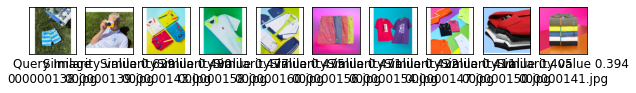

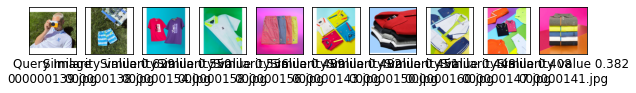

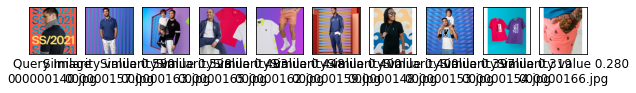

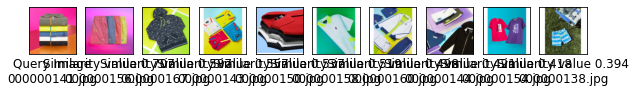

In [ ]:
# Let's take the top images for some example images
inputImages = ['000000138.jpg', '000000139.jpg', '000000140.jpg', '000000141.jpg']

numCol = 10
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(10, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)

In [ ]:
def plot_images(images, figsize = (16,16), w=10, h=10, columns=6, rows=6):
  """
  Function to plot several images.
  
  Parameters
  ----------
  images : list
      List of image names.
  """
  fig = plt.figure(figsize=figsize)
  count = 1
  
  for image in images:
      img = Image.open(os.path.join(inputDir, image))
      fig.add_subplot(rows, columns, count)
      count +=1
      plt.imshow(img)
  plt.show()

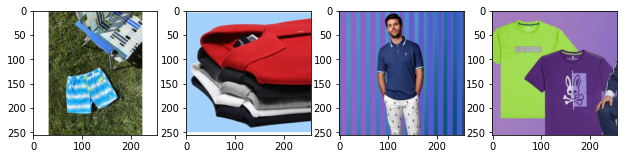

In [ ]:
liked_images = ['000000138.jpg', '000000150.jpg', '000000157.jpg', '000000164.jpg']
plot_images(liked_images)

In [ ]:
# Get recommendations
recos = []
for image in liked_images:
  simImages, simValues = getSimilarImages(image, similarNames, similarValues)
  all_images = [image]
  all_images.extend(simImages)
  recos.extend(all_images)

The first column has the "query" images so each row contains the recommendations for each query image.


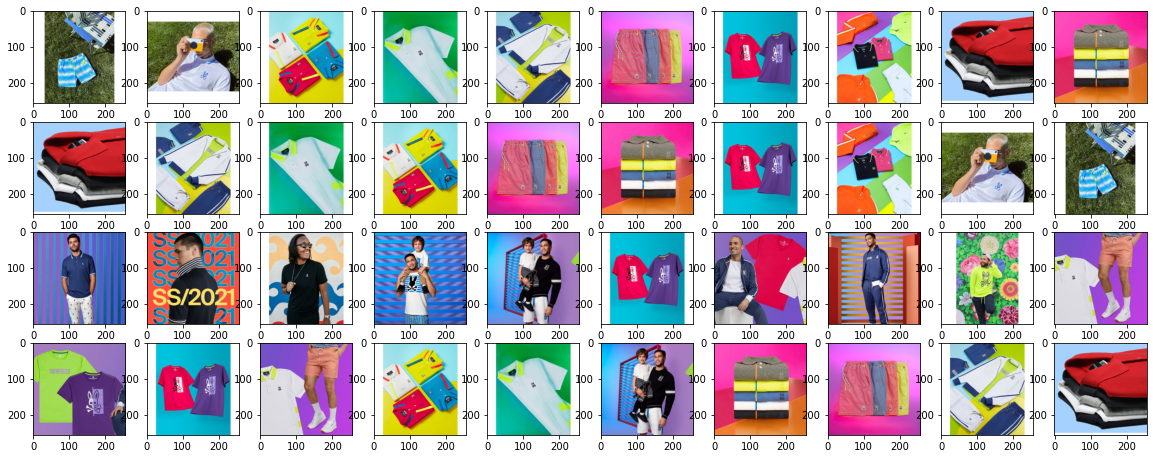

In [ ]:
plot_images(recos, figsize = (20,20), w=20, h=20, columns=10, rows=10)